# Model

In [1]:
from modeller import *

In [6]:
env = environ()
aln = alignment(env)
mdl = model(env, file='3rfm')
aln.append_model(mdl, align_codes='3rfm', atom_files='3rfm.pdb')
aln.append(file='A2A_mutant.txt', alignment_format='FASTA')
aln.align2d()
aln.write(file='mutant-3rfm.ali', alignment_format='PIR')
aln.write(file='mutant-3rfm.pap', alignment_format='PAP')

mkapsa__637W> No residue topology library is in memory.
              Better radii would be used if topology.read() is called first.
iup2crm_280W> No topology library in memory or assigning a BLK residue.
              Default CHARMM atom type assigned:  N -->  N
              This message is written only for the first such atom.

Pairwise dynamic programming alignment (ALIGN2D):
  Residue-residue metric   : $(LIB)/as1.sim.mat
  Diagonal                 :          100
  Overhang                 :            0
  Maximal gap length       :       999999
  Local alignment          :            F
  MATRIX_OFFSET (local aln):       0.0000
  FIX_OFFSETS              :      0.0    -1.0    -2.0    -3.0    -4.0
  N_SUBOPT                 :            0
  SUBOPT_OFFSET            :       0.0000
  Alignment block          :            1
  Gap introduction penalty :    -100.0000
  Gap extension penalty    :       0.0000
  Gap diagonal penalty     :       0.0000
  Structure gap penalties  :    3.500

In [7]:
aln

Alignment of Structure '3rfm', Sequence 'A2A_mutant'

In [8]:
from modeller import *
from modeller.automodel import *

env = environ()
a = automodel(env, alnfile='mutant-3rfm.ali',
              knowns='3rfm', sequence='A2A_mutant',
              assess_methods=(assess.DOPE, assess.GA341))
a.starting_model = 1
a.ending_model = 5
a.make()


check_ali___> Checking the sequence-structure alignment. 

Implied intrachain target CA(i)-CA(i+1) distances longer than  8.0 angstroms:

ALN_POS  TMPL  RID1  RID2  NAM1  NAM2     DIST
----------------------------------------------
    149     1  149   158      P     K   13.886
END OF TABLE
read_to_681_> topology.submodel read from topology file:        3
patch_s_522_> Number of disulfides patched in MODEL:        4
mdtrsr__446W> A potential that relies on one protein is used, yet you have at
              least one known structure available. MDT, not library, potential is used.
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies
condens_443_> Restraints marked for deletion were removed.
              Total number of restraints before, now:    33167    30260
iupac_m_397W> Atoms were not swapped because of the uncertainty of how to handle

In [2]:
from modeller.scripts import complete_pdb

env = environ()
env.libs.topology.read(file='$(LIB)/top_heav.lib') # read topology
env.libs.parameters.read(file='$(LIB)/par.lib') # read parameters

# read model file
mdl = complete_pdb(env, 'A2A_mutant.B99990003.pdb')

# Assess with DOPE:
s = selection(mdl)   # all atom selection
s.assess_dope(output='ENERGY_PROFILE NO_REPORT', file='A2A_mutant.profile',
              normalize_profile=True, smoothing_window=15)

# read model file
md2 = complete_pdb(env, '3rfm.pdb')

# Assess with DOPE:
s = selection(md2)   # all atom selection
s.assess_dope(output='ENERGY_PROFILE NO_REPORT', file='3rfm.profile',
              normalize_profile=True, smoothing_window=15)


                         MODELLER 9.25, 2020/09/03, r11894

     PROTEIN STRUCTURE MODELLING BY SATISFACTION OF SPATIAL RESTRAINTS


                     Copyright(c) 1989-2020 Andrej Sali
                            All Rights Reserved

                             Written by A. Sali
                               with help from
              B. Webb, M.S. Madhusudhan, M-Y. Shen, G.Q. Dong,
          M.A. Marti-Renom, N. Eswar, F. Alber, M. Topf, B. Oliva,
             A. Fiser, R. Sanchez, B. Yerkovich, A. Badretdinov,
                     F. Melo, J.P. Overington, E. Feyfant
                 University of California, San Francisco, USA
                    Rockefeller University, New York, USA
                      Harvard University, Cambridge, USA
                   Imperial Cancer Research Fund, London, UK
              Birkbeck College, University of London, London, UK


Kind, OS, HostName, Kernel, Processor: 4, WinNT 10.0 build 18363, DESKTOP-PT0DDL5, SMP, unknown
Date and time

-41409.78515625

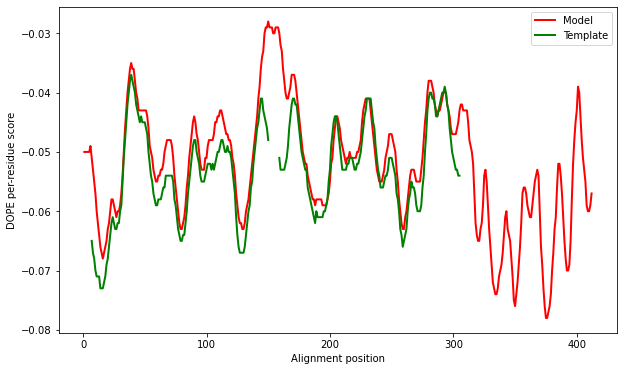

In [4]:
import pylab
import modeller

def r_enumerate(seq):
    """Enumerate a sequence in reverse order"""
    # Note that we don't use reversed() since Python 2.3 doesn't have it
    num = len(seq) - 1
    while num >= 0:
        yield num, seq[num]
        num -= 1

def get_profile(profile_file, seq):
    """Read `profile_file` into a Python array, and add gaps corresponding to
       the alignment sequence `seq`."""
    # Read all non-comment and non-blank lines from the file:
    f = open(profile_file)
    vals = []
    for line in f:
        if not line.startswith('#') and len(line) > 10:
            spl = line.split()
            vals.append(float(spl[-1]))
    # Insert gaps into the profile corresponding to those in seq:
    for n, res in r_enumerate(seq.residues):
        for gap in range(res.get_leading_gaps()):
            vals.insert(n, None)
    # Add a gap at position '0', so that we effectively count from 1:
    vals.insert(0, None)
    return vals

e = modeller.environ()
a = modeller.alignment(e, file='mutant-3rfm.ali')

template = get_profile('3rfm.profile', a['3rfm'])
model = get_profile('A2A_mutant.profile', a['A2A_mutant'])

pylab.figure(1, figsize=(10,6))
pylab.xlabel('Alignment position')
pylab.ylabel('DOPE per-residue score')
pylab.plot(model, color='red', linewidth=2, label='Model')
pylab.plot(template, color='green', linewidth=2, label='Template')
pylab.legend()
pylab.savefig('dope_profile.svg', dpi=65)